In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
sys.path.insert(1, oj(sys.path[0], '..', 'vision_fit'))  # insert parent path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import math
# plt.style.use('dark_background')
from mog_fit import data
from collections import OrderedDict
from sklearn import preprocessing

import torch
from torch.autograd import Variable
from mog_analyze import viz
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

from vision_fit import data
import viz_weights
from process_results import process_results

%matplotlib inline
%load_ext autoreload
%autoreload 2

import style
cb = '#008fd5'
cr = '#fc4f30'

In [2]:
style.set_style()

# load results from a directory

In [3]:
# depending on how much is saved, this may take a while
out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/simple_dsets/all_flips'
fnames = sorted([oj(out_dir, fname) for fname in os.listdir(out_dir)])
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in tqdm(fnames) 
                if not 'weights' in fname and not 'idx' in fname]
results = pd.concat(results_list, axis=1).T.infer_objects()
print(results.shape)

100%|██████████| 144/144 [00:00<00:00, 370.29it/s]

(48, 58)


**add cols**

In [4]:
# adds these vec keys: fc0_fro, fc1_fro, fc0_stab_rank, fc1_stab_rank, act0_stab_rank, act1_stab_rank, corr0, corr1
# adds these scalar keys: max_train_acc, max_test_acc, _final of all the above
# print('before', results.shape)
its, ts, results = process_results(results)
print('after', results.shape)

after (38, 88)


# pick example

In [5]:
# weights
fnames_w = [fname for fname in fnames if 'weights' in fname]
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in fnames_w]
rw = pd.concat(results_list, axis=1).T.infer_objects()

# normal results
fnames_acc = [fname for fname in fnames if not 'weights' in fname and not 'idx' in fname] # normal results
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in fnames_acc]
r = pd.concat(results_list, axis=1).T.infer_objects()

# get individual weights
rw_sgd = rw[rw.optimizer == 'sgd'].reset_index().iloc[0]

# get accs
r_sgd = r[r.optimizer == 'sgd'].reset_index().iloc[0]

# plot lay1 weights

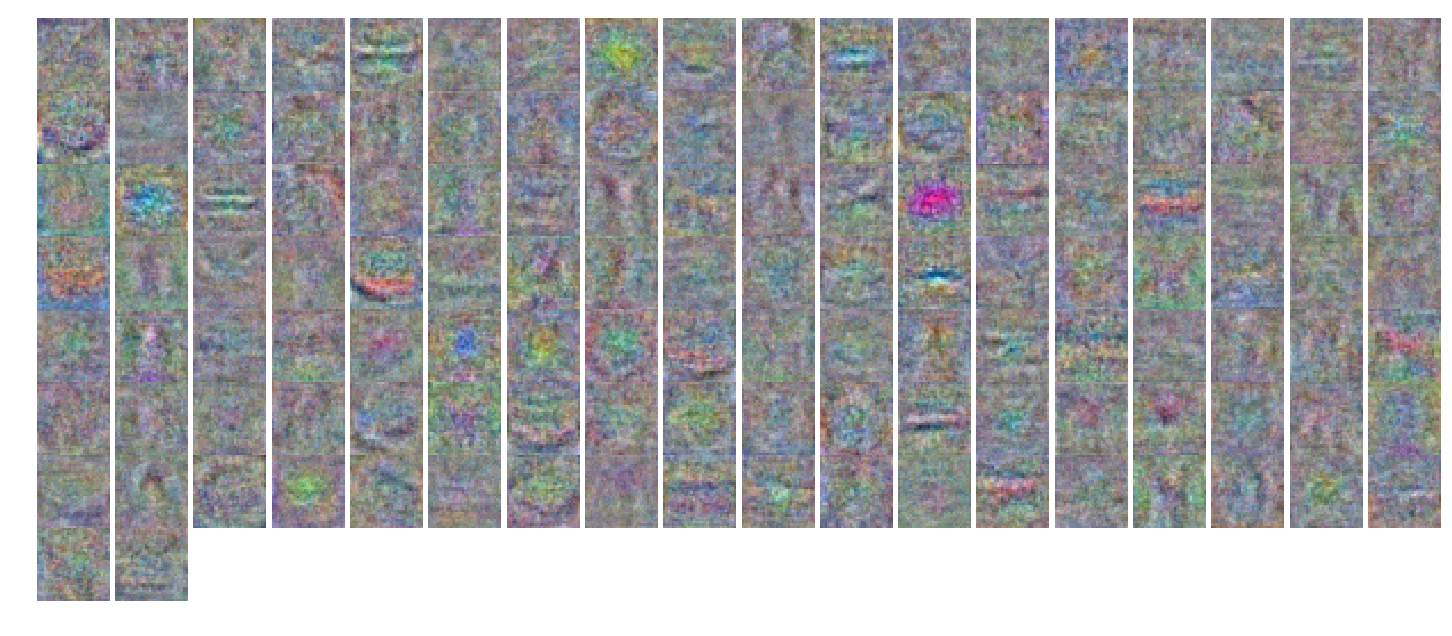

In [7]:
from matplotlib.ticker import NullLocator

def get_w(run):
    run['num_layer'] = int(run['num_layers'])
    run['hidden_size'] = int(run['hidden_size'])
    lay = 'fc.0.weight'

    # keys are epochs, vals are dicts of all weights
    weights_dict_dict = run['weights']

    # keys are layers, vals are weight values
    epoch = max(weights_dict_dict.keys())
    weights_dict = weights_dict_dict[epoch]
#     print(weights_dict.keys())
    w = weights_dict[lay]

    return w

for run in [rw_sgd]:
    w = get_w(run)
    # matrix of weights (output x input)
    viz_weights.plot_weights(w, dset=run.dset, C=18, dpi=120)
                
    plt.gca().set_axis_off()
    plt.gca().xaxis.set_major_locator(NullLocator())
    plt.gca().yaxis.set_major_locator(NullLocator())
    plt.margins(0, 0)

#     plt.savefig(run.optimizer + '_' + str(run.hidden_size) + '_' + 'w0.pdf', 
#                 bbox_inches = 'tight', pad_inches = 0)

In [8]:
run = rw_sgd
print(run.optimizer)

# get data
run['num_layer'] = int(run['num_layers'])
run['hidden_size'] = int(run['hidden_size'])
run['batch_size'] = int(run.batch_size)
print(run.dset, run.flip_iter)
train_loader, test_loader = data.get_data_loaders(run)
X_train, Y_train, X_test, Y_test = data.process_loaders(train_loader, test_loader)


# load in weights
model = data.get_model(run)
weights_dict_dict = run['weights'] # keys are epochs, vals are dicts of all weights
epoch = max(weights_dict_dict.keys())
weights_dict = weights_dict_dict[epoch] # keys are layers, vals are weight values    
weights_dict_tensors = {k: torch.Tensor(v) for k, v in weights_dict.items()}
model.load_state_dict(weights_dict_tensors)
model = model.cuda()

sgd
cifar10_5_5_flip 30
Files already downloaded and verified
Files already downloaded and verified


# look at margin

In [9]:
import torch.nn.functional as F
import torch.optim as optim

In [24]:
# calculate loss, accuracy, and margin
def calc_loss_acc_margins(loader, batch_size, use_cuda, model, criterion, print_loss=False):
    correct_cnt, tot_loss_test = 0, 0
    n_test = len(loader) * batch_size
    margin_sum_norm, margin_sum_unnormalized = 0, 0
    confidence_sum_norm, confidence_sum_unnormalized = 0, 0
    for batch_idx, (x, class_label) in enumerate(loader):
        if use_cuda:
            x, class_label = x.cuda(), class_label.cuda()
        out = model(x)
        
        # calc acc
        _, class_max_pred = torch.max(out.data, 1)
        correct_cnt += (class_max_pred == class_label.data).sum().item()
        
        # calc loss
        loss = criterion(out, class_label)
        tot_loss_test += loss.item()
        class_label = class_label.cpu()
        
        # set up margins (unn - before softmax, norm - with softmax)
        n = out.data.shape[0]
        preds_unn = out.data.cpu().numpy()
        preds_norm = F.softmax(out, dim=1).data.cpu().numpy()
        class_max_pred = class_max_pred.cpu()
        mask_max_pred = np.ones(preds_unn.shape).astype(bool)
        mask_max_pred[np.arange(n), class_max_pred] = False
        mask_label = np.ones(preds_unn.shape).astype(bool)
        mask_label[np.arange(n), class_label] = False
        
        # confidence (top pred - 2nd pred) - this cannot be negative
        preds_unn_class = preds_unn[np.arange(n), class_max_pred] # top pred class
        preds_unn_alt = preds_unn[mask_max_pred].reshape(n, -1) # remove top pred class
        preds_unn_class2 = np.max(preds_unn_alt, axis=1) # 2nd top pred class
        confidence_sum_unnormalized += np.sum(preds_unn_class) - np.sum(preds_unn_class2)
        
        preds_norm_class = preds_norm[np.arange(n), class_max_pred]
        preds_norm_alt = preds_norm[mask_max_pred].reshape(n, -1)
        preds_norm_class2 = np.max(preds_norm_alt, axis=1)
        confidence_sum_norm += np.sum(preds_norm_class) - np.sum(preds_norm_class2)
        
        # margins (label - top non-label pred) - this can be negative
        preds_unn_class = preds_unn[np.arange(n), class_label] # label class
        preds_unn_alt = preds_unn[mask_label].reshape(n, -1) # remove label class
        preds_unn_class2 = np.max(preds_unn_alt, axis=1) # 2nd top pred class
        margin_sum_unnormalized += np.sum(preds_unn_class) - np.sum(preds_unn_class2)
        
        preds_norm_class = preds_norm[np.arange(n), class_label]
        preds_norm_alt = preds_norm[mask_label].reshape(n, -1)
        preds_norm_class2 = np.max(preds_norm_alt, axis=1)
        margin_sum_norm += np.sum(preds_norm_class) - np.sum(preds_norm_class2)        
        
    if print_loss:    
        print('==>>> loss: {:.6f}, acc: {:.3f}, margin: {:.3f}'.format(tot_loss_test / n_test, correct_cnt * 1.0 / n_test, margin_sum_norm / n_test))
    
    # returns loss, acc, margin_unnormalized, margin_normalized
    return [x / n_test for x in [tot_loss_test, 1.0 * correct_cnt, 
                                 confidence_sum_unnormalized, confidence_sum_norm, margin_sum_unnormalized, margin_sum_norm]]
            
a,b,c,d,e,f = calc_loss_acc_margins(train_loader, 100, True, model, 
                  nn.CrossEntropyLoss(), print_loss=True)

ret_test = calc_loss_acc_margins(test_loader, 100, True, model, 
                  nn.CrossEntropyLoss(), print_loss=True)


==>>> loss: 0.002185, acc: 0.976, margin: 0.784
==>>> loss: 0.043949, acc: 0.000, margin: -0.717


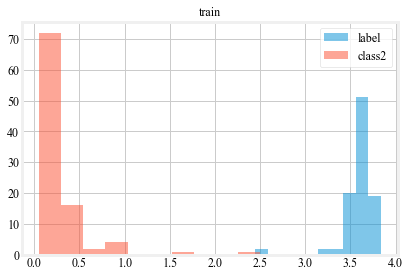

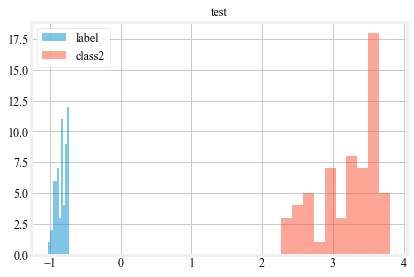

In [21]:
(preds_unn_class, preds_unn_class2) = ret_train[1]
plt.title('train')
plt.hist(preds_unn_class, label='label')
plt.hist(preds_unn_class2, label='class2')
plt.legend()
plt.show()

(preds_unn_class, preds_unn_class2) = ret_test[1]
plt.title('test')
plt.hist(preds_unn_class, label='label')
plt.hist(preds_unn_class2, label='class2')
plt.legend()
plt.show()